### Model, dassAnzahl SpikeFault vorhersagt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.impute import SimpleImputer

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate,StratifiedKFold, cross_val_score, train_test_split
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder,MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor

In [15]:
#read data scikit-learn
os.chdir('C:/Users/Katharina/Desktop/Weiterbildung/Bootcamp/Bootcamp/Final_project/data')
#data = pd.read_csv('DatenML_V2_relCol.csv', sep=';')
data = pd.read_csv('DatenML_V2_relCol_ZusatzType.csv', sep=';')		


In [16]:
df = data
# Erstellen der neuen Spalte "Team1":
# Wenn TeamDesignation = A, dann soll TeamAName in Team1 stehen,
# andernfalls (also bei B) TeamBName.
df["Team1"] = np.where(
    df["TeamDesignation"].str.upper() == "A",
    df["@TeamAName"],
    df["@TeamBName"]
)

# Erstellen der Spalte "Team2" als das jeweils andere Team:
df["Team2"] = np.where(
    df["TeamDesignation"].str.upper() == "A",
    df["@TeamBName"],
    df["@TeamAName"]
)

In [30]:
#Gender umdefinieren
df['Gender_x'] = df['Gender_x'].astype('object')

In [31]:
#bestimmte Variablen entfernen
# data1 = df.drop(['FirstName', 'LastName', 'TeamDesignation', '@PointsTeamASet3', '@PointsTeamBSet3', 
#        'FederationCode_y', '@TeamAName', '@TeamBName','Gender_x','TeamName',
#        '@LocalDate', '@LocalTime',
#         'SpikeTotal',
#         '@DurationSet3'], axis=1)
data1 = df.drop(['FirstName', 'LastName', 'TeamDesignation','@PointsTeamASet1', '@PointsTeamBSet1', '@PointsTeamASet2',
       '@PointsTeamBSet2', '@PointsTeamASet3', '@PointsTeamBSet3', 
       'FederationCode_y', '@TeamAName', '@TeamBName',
       '@DurationSet1','@LocalDate', '@LocalTime','SpikeTotal',
       #neu
       'FirstName2', 'LastName2','Type','TournamentNo','NoPlayer1_team', 'NoPlayer2_team',#'total_A', 'total_B', 'TeamName'-> nicht mehr da
       '@DurationSet2', '@DurationSet3'], axis=1)
#'Gender_x',

In [32]:
y = data1.pop('SpikeFault')
X = data1.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31416)

In [29]:
df.to_csv('ML_SpikeFault_mitWetter_V2.csv', index=False, sep=';')

In [25]:
train_data = X_train.copy()
train_data['SpikeFault'] = y_train

### Analyse

In [27]:
train_data.columns

Index(['SpikePoint', 'ServeFault', 'ServePoint', 'ServeTotal', 'BlockPoint',
       'BlockTotal', 'DigTotal', 'ReceptionFault', '@PointsTeamASet1',
       '@PointsTeamBSet1', '@PointsTeamASet2', '@PointsTeamBSet2',
       '@DurationSet1', '@DurationSet2', 'temperature_2m', 'precipitation',
       'wind_speed_10m', 'rain', 'wind_gusts_10m', 'TeamFault_team',
       'match_win', 'total_A', 'total_B', 'Team1', 'Team2', 'SpikeFault'],
      dtype='object')

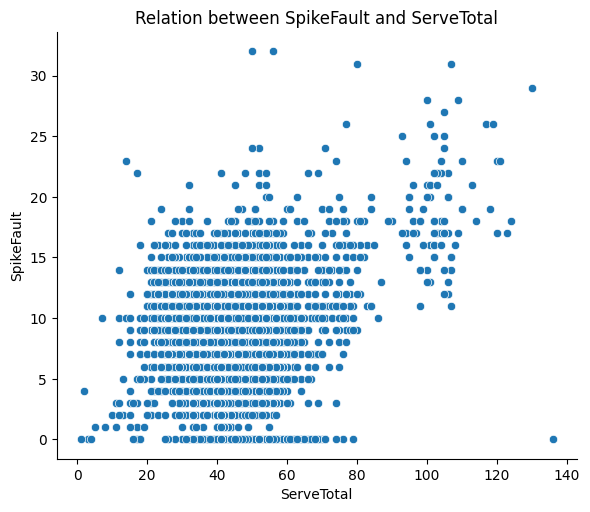

In [28]:
(
  sns.relplot(data=train_data,
              x='ServeTotal',
              y='SpikeFault',
              height=5,
              aspect=1.2)
  .set(title='Relation between SpikeFault and ServeTotal')
  .set_axis_labels('ServeTotal', 'SpikeFault')
);

### Modell

In [33]:
# select categorical and numerical column names
nominal_features = X.select_dtypes(include=['object']).columns.tolist()
# Define feature types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Create preprocessors for different feature types
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Build the column transformer
transformers = [
    ('num', numeric_transformer, numeric_features),
    ('nom', nominal_transformer, nominal_features)
]

preprocessor = ColumnTransformer(transformers=transformers)

In [23]:
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

model_scores = []
def score_model(model_name, y_true, y_pred):
  scores = {
      'Model': model_name,
      'MAE ($)': round(mean_absolute_error(y_true, y_pred), 2),
      'RMSE ($)': round(root_mean_squared_error(y_true, y_pred), 2),
      'MAPE (%)': round(100 * mean_absolute_percentage_error(y_true, y_pred), 2),
      'R-Squared': round(r2_score(y_true, y_pred), 3)
  }
  return scores

In [24]:
sgd_pipeline = make_pipeline(preprocessor,
                             RobustScaler(),
                             SGDRegressor(random_state=42))

sgd_pipeline.fit(X_train, y_train)

sgd_predictions = sgd_pipeline.predict(X_test)
model_scores.append(score_model('Stochastic Gradient Descent', y_test, sgd_predictions))
pd.DataFrame(model_scores)

,Model,MAE ($),RMSE ($),MAPE (%),R-Squared
0,Stochastic Gradient Descent,2.42,3.13,6.221068e+16,0.332


In [34]:
from sklearn.ensemble import GradientBoostingRegressor
gbr_pipeline = make_pipeline(preprocessor,
                             RobustScaler(),
                             GradientBoostingRegressor(random_state=42, n_estimators=200, learning_rate=0.1, 
                                                  max_depth=5, subsample=0.8))

GB = gbr_pipeline.fit(X_train, y_train)

gbr_predictions = gbr_pipeline.predict(X_test)

model_scores.append(score_model('GradientBoostigRegressor', y_test, gbr_predictions))
pd.DataFrame(model_scores)

,Model,MAE ($),RMSE ($),MAPE (%),R-Squared
0,Stochastic Gradient Descent,2.42,3.13,6.221068e+16,0.332
1,GradientBoostigRegressor,2.19,2.83,2.773325e+16,0.451
2,RandomForest,2.19,2.87,2.488979e+16,0.439
3,GradientBoostigRegressor,2.19,2.83,2.702596e+16,0.453


In [35]:
import joblib
# Modell speichern als .pkl-Datei
joblib.dump(GB, "GradientBoosting_SpikeFault_mitWetter_V2.pkl")

['GradientBoosting_SpikeFault_mitWetter_V2.pkl']

In [58]:
print(gbr_pipeline.named_steps['gradientboostingregressor'].get_params())


{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [36]:
from sklearn.ensemble import RandomForestRegressor
rf_pipeline = make_pipeline(preprocessor,
                             RobustScaler(),
                             RandomForestRegressor(random_state=42, n_estimators=200, max_depth=15, 
                                         min_samples_split=5, min_samples_leaf=2))

RF = rf_pipeline.fit(X_train, y_train)

rf_predictions = rf_pipeline.predict(X_test)

model_scores.append(score_model('RandomForest', y_test, rf_predictions))
pd.DataFrame(model_scores)

,Model,MAE ($),RMSE ($),MAPE (%),R-Squared
0,Stochastic Gradient Descent,2.42,3.13,6.221068e+16,0.332
1,GradientBoostigRegressor,2.19,2.83,2.773325e+16,0.451
2,RandomForest,2.19,2.87,2.488979e+16,0.439
3,GradientBoostigRegressor,2.19,2.83,2.702596e+16,0.453
4,RandomForest,2.19,2.87,2.506834e+16,0.439


In [37]:
import joblib
# Modell speichern als .pkl-Datei
joblib.dump(RF, "RandomForest_SpikeFault_mitWetter_V2.pkl")

['RandomForest_SpikeFault_mitWetter_V2.pkl']

In [ ]:
print(rf_pipeline.named_steps['randomforestregressor'].get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


## old

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Hyperparameter für RandomForestRegressor
rf_param_grid = {
    #"randomforestregressor__n_estimators": [50, 100],  # Anzahl der Bäume
    "randomforestregressor__max_depth": range(3, 8, 2),  # Maximale Tiefe
    "randomforestregressor__min_samples_split": [2, 5, 10],  # Mindestanzahl an Samples für einen Split
    #"randomforestregressor__min_samples_leaf": [3, 5]  # Mindestanzahl von Samples pro Blattknoten
}

In [22]:
pipe = make_pipeline(preprocessor, MinMaxScaler(), RandomForestRegressor(random_state=123))

    # GridSearchCV will test all possible combinations of parameters defined in 'param_grid'
grid_search = GridSearchCV(pipe, rf_param_grid, cv=5, n_jobs=-1)

    # Fit the model on the training data with the various parameter combinations
grid_rf = grid_search.fit(X_train, y_train)

In [23]:
print(f"Beste Parameter: {grid_rf.best_params_}")
print(f"Bester Score: {grid_rf.best_score_:.4f}") #anpassen


Beste Parameter: {'randomforestregressor__max_depth': 7, 'randomforestregressor__min_samples_split': 2}
Bester Score: 0.4559


In [ ]:
# from sklearn.ensemble import GradientBoostingRegressor

# # Hyperparameter für GradientBoostingRegressor
# gb_param_grid = {
#     "gradientboostingregressor__n_estimators": [50, 100,],  # Anzahl der Boosting-Iterationen
#    # "gradientboostingregressor__learning_rate": [0.01, 0.1, 0.2],  # Lernrate
#     "gradientboostingregressor__max_depth": range(3, 10, 2),  # Maximale Tiefe der Bäume
#     "gradientboostingregressor__min_samples_split": [2, 5, 10],  # Mindestanzahl an Samples für einen Split
#     "gradientboostingregressor__min_samples_leaf": [1, 3, 5]  # Mindestanzahl von Samples pro Blattknoten
# }

# # Grid Search für GradientBoostingRegressor
# gb_search = run_grid_search(
#     GradientBoostingRegressor(random_state=123),
#     gb_param_grid,
# )

# # Evaluate the K-Nearest Neighbours (KNN) model using the testing dataset and obtain performance metrics
# gb_scores = evaluate_model(rf_search, "GradientBoosting")

# # Append the KNN metrics as a new row to the existing DataFrame of model scores
# model_scores_df = track_model_scores(model_scores_df, gb_scores)

# # Display the updated DataFrame containing all model performance metrics
# model_scores_df

variante 2


Training RandomForest...
RandomForest - Cross-validation R² Score: 0.4970 (±0.0203)

Training GradientBoosting...
GradientBoosting - Cross-validation R² Score: 0.5208 (±0.0203)

Top 20 most important features:
             Feature  Importance
3         ServeTotal    0.256151
20         match_win    0.212777
19    TeamFault_team    0.117815
14    temperature_2m    0.037610
7     ReceptionFault    0.036903
12     @DurationSet1    0.031379
16    wind_speed_10m    0.030873
13     @DurationSet2    0.030711
0         SpikePoint    0.026904
4         BlockPoint    0.026408
18    wind_gusts_10m    0.019035
1         ServeFault    0.016175
6           DigTotal    0.015064
9   @PointsTeamBSet1    0.014711
11  @PointsTeamBSet2    0.014210
8   @PointsTeamASet1    0.013288
5         BlockTotal    0.013161
10  @PointsTeamASet2    0.011964
2         ServePoint    0.011923
22           total_B    0.004499


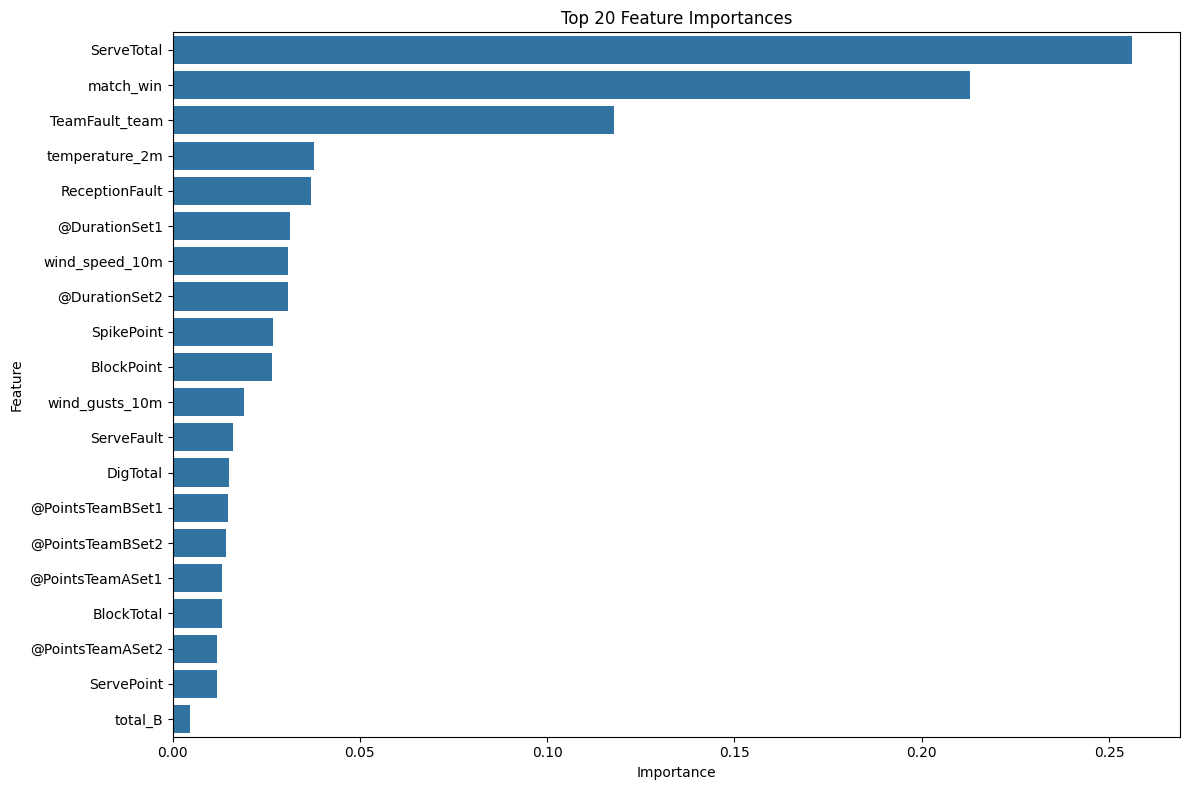

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define models
models = {
    'RandomForest': RandomForestRegressor(random_state=42, n_estimators=200, max_depth=15, 
                                          min_samples_split=5, min_samples_leaf=2),
    'GradientBoosting': GradientBoostingRegressor(random_state=42, n_estimators=200, learning_rate=0.1, 
                                                  max_depth=5, subsample=0.8)
}

# Setup cross-validation (KFold statt StratifiedKFold)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to train and evaluate models
def evaluate_model(name, model, X, y, cv):
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Cross-validation scores (Regression → R² oder MSE)
    cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')  # Alternativ: 'neg_mean_squared_error'
    
    print(f"{name} - Cross-validation R² Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    # Train on full dataset for feature importance
    pipeline.fit(X, y)
    
    return pipeline

# Evaluate all models
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    pipeline = evaluate_model(name, model, X, y, cv)
    trained_models[name] = pipeline
########################################################################################################
# Get feature importance from one of the tree-based models (e.g., Random Forest)
rf_model = trained_models['RandomForest']
preprocessed_X = rf_model.named_steps['preprocessor'].transform(X)

# Get feature names after preprocessing
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(cols)
    elif name == 'nom':
        ohe = trans.named_steps['onehot']
        feature_names.extend([f"{col}_{cat}" for col in cols 
                            for cat in ohe.categories_[cols.index(col)]])
    else:  # ordinal features
        feature_names.append(name[4:])  # Entferne 'ord_' Präfix

# Get and display feature importances (Anpassung für Regression)
if hasattr(rf_model.named_steps['regressor'], 'feature_importances_'):
    importances = rf_model.named_steps['regressor'].feature_importances_
    
    # Create DataFrame with feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_names[:len(importances)],  # Länge sicherstellen
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display top 20 features
    print("\nTop 20 most important features:")
    print(importance_df.head(20))
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()


In [69]:
#Output für GBR
# Get feature importance from one of the tree-based models (e.g., Random Forest)
gbr_model = trained_models['GradientBoosting']
preprocessed_X_gbr = gbr_model.named_steps['preprocessor'].transform(X)

# Get feature names after preprocessing
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(cols)
    elif name == 'nom':
        ohe = trans.named_steps['onehot']
        # feature_names.extend([f"{col}_{cat}" for col in cols 
        #                     for cat in ohe.categories_[cols.index(col)]])
    # else:  # ordinal features
    #     feature_names.append(name[4:])  # Entferne 'ord_' Präfix

# Get and display feature importances (Anpassung für Regression)
if hasattr(rf_model.named_steps['regressor'], 'feature_importances_'):
    importances = rf_model.named_steps['regressor'].feature_importances_
    
    # Create DataFrame with feature importances
    importance_df = pd.DataFrame({
        'Feature': feature_names[:len(importances)],  # Länge sicherstellen
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Display top 20 features
    print("\nTop 20 most important features:")
    print(importance_df.head(20))
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()


KeyboardInterrupt



optimieren: 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "randomforestregressor__n_estimators": [50, 100, 200],  
    "randomforestregressor__max_depth": [3, 5, 10],  
    "randomforestregressor__min_samples_split": [2, 5, 10]  
}

random_search = RandomizedSearchCV(pipe, param_dist, cv=5, scoring="r2", n_iter=10, n_jobs=-1)
random_search.fit(X_train, y_train)

print(f"Beste Parameter: {random_search.best_params_}")
print(f"Bester Score: {random_search.best_score_:.4f}")


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
    pipeline = make_pipeline(preprocessor, model)

    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring="r2").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # 20 verschiedene Kombinationen testen

print(f"Beste Parameter: {study.best_params}")
print(f"Bester Score: {study.best_value:.4f}")


In [ ]:
# #Model Building
# # Define models
# models = {
#     'RandomForest': RandomForestRegressor(random_state=42, n_estimators=200, max_depth=15, 
#                                          min_samples_split=5, min_samples_leaf=2),
#      'GradientBoosting': GradientBoostingRegressor(random_state=42, n_estimators=200, learning_rate=0.1, 
#                                                   max_depth=5, subsample=0.8)
# }

# # Setup cross-validation
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

# # Function to train and evaluate models
# def evaluate_model(name, model, X, y, cv):
#     pipeline = Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('regressor', model)
#     ])
    
#     # Cross-validation scores
#     cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2')
    
#     print(f"{name} - Cross-validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
#     # Train on full dataset for feature importance
#     pipeline.fit(X, y)
    
#     return pipeline

#     # Evaluate all models
# trained_models = {}

# for name, model in models.items():
#     print(f"\nTraining {name}...")
#     pipeline = evaluate_model(name, model, X, y, cv)
#     trained_models[name] = pipeline

# # Get feature importance from one of the tree-based models (e.g., Random Forest)
# rf_model = trained_models['GradientBoosting']
# preprocessed_X = rf_model.named_steps['preprocessor'].transform(X)

# # Get feature names after preprocessing
# feature_names = []
# for name, trans, cols in preprocessor.transformers_:
#     if name == 'num':
#         feature_names.extend(cols)
#     elif name == 'nom':
#         ohe = trans.named_steps['onehot']
#         feature_names.extend([f"{col}_{cat}" for col in cols 
#                             for cat in ohe.categories_[cols.index(col)]])
#     else:  # ordinal features
#         feature_names.append(name[4:])  # Remove 'ord_' prefix

# # Get and display feature importances
# if hasattr(rf_model.named_steps['regressor'], 'feature_importances_'):
#     importances = rf_model.named_steps['regressor'].feature_importances_
    
#     # Create DataFrame with feature importances
#     importance_df = pd.DataFrame({
#         'Feature': feature_names[:len(importances)],  # Ensure lengths match
#         'Importance': importances
#     }).sort_values('Importance', ascending=False)
    
#     # Display top 20 features
#     print("\nTop 20 most important features:")
#     print(importance_df.head(20))
    
#     # Plot feature importances
#     plt.figure(figsize=(12, 8))
#     sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
#     plt.title('Top 20 Feature Importances')
#     plt.tight_layout()